In [ ]:
import torch
import math

class legendrePolynomial(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, t):
        
        ctx.save_for_backward(t)
        return 0.5 * (5*t**3 - 3*t)
    
    
    @staticmethod
    def backward(ctx, grad_output):
        
        t, = ctx.saved_tensors
        return grad_output * (0.5 * (15*t**2 - 3))
    

dtype = torch.float32
device = torch.device('cuda')

x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)


a = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
b = torch.full((), -1.0, device=device, dtype=dtype, requires_grad=True)
c = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
d = torch.full((), 0.3, device=device, dtype=dtype, requires_grad=True)


learning_rate = 5e-6

for epoch in range(2000):
    
    P3 = legendrePolynomial.apply
    
    y_pred = a + b * P3(c + d * x)
    
    
    loss = (y_pred - y).pow(2).sum()
    
    if epoch % 100 == 99:
        print(epoch, loss.item())
        
    loss.backward()
    
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None

print(f'Result: y = {a.item()} + {b.item()} * P3({c.item()} + {d.item()} x)')

In [1]:
import torch
import math

In [2]:
from pathlib import Path
import requests

In [3]:
Data_Path = Path("data")
path_ = Data_Path / "mnist"

In [4]:
path_.mkdir(parents = True, exist_ok =True)

In [5]:
URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

In [6]:
if not (path_ / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (path_ / FILENAME).open("wb").write(content)

In [7]:
import pickle
import gzip

with gzip.open((path_ / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


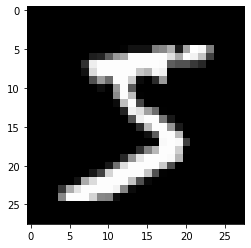

In [9]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [10]:
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [ ]:
import math

In [21]:
weights = torch.randn(28*28, 10) / math.sqrt(28*28)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [12]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb@weights + bias)

In [22]:
bs = 64

xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape

(tensor([-1.9268, -2.0531, -2.6870, -2.0175, -2.6792, -2.6508, -2.2957, -2.3653,
         -2.7284, -2.0726], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [14]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [23]:
yb = y_train[0:bs]

loss_func(preds, yb)

tensor(2.2855, grad_fn=<NegBackward>)

In [16]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [24]:
print(accuracy(preds, yb))

tensor(0.1562)


In [25]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(2.2855, grad_fn=<NegBackward>) tensor(0.1562)


In [26]:
lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
    
        preds = model(xb)
    
        loss = loss_func(preds, yb)
    
        loss.backward()
        
        with torch.no_grad():
            weights -= lr * weights.grad
            bias -= lr * bias.grad
        
            weights.grad.zero_()
            bias.grad.zero_()

In [27]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0818, grad_fn=<NegBackward>) tensor(1.)


In [28]:
import torch.nn.functional as F

In [29]:
loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [30]:
from torch import nn

class mnist_logistic(nn.Module):
    
    def __init__(self):
        super(mnist_logistic, self).__init__()
        
        self.weights = nn.Parameter(torch.randn(28*28, 10) / math.sqrt(28*28))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, xb):
        return xb @ self.weights + self.bias

In [31]:
model = mnist_logistic()

In [32]:
loss_func(model(xb), yb)

tensor(2.4212, grad_fn=<NllLossBackward>)

In [33]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
fit()

In [34]:
print(loss_func(model(xb), yb))

tensor(0.0825, grad_fn=<NllLossBackward>)


In [ ]:
class mnist_logistic(nn.Module):
    